# Определение возраста покупателей

**Задача:**
Построить модель, которая по фотографии определит приблизительный возраст человека. Есть набор фотографий людей с указанием возраста.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Исследовательский анализ данных

Загрузим данные

In [2]:
# Загрузка данных из CSV-файла
csv_path = '/datasets/faces/labels.csv'
df = pd.read_csv(csv_path)

In [3]:
# Вывод информации о размере выборки
print("Размер выборки:", len(df))

Размер выборки: 7591


Размер выборки позволяет рассчитывать не хороший результал

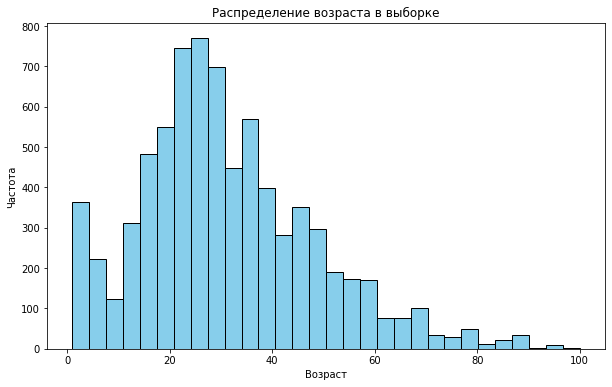

In [4]:
# Построение графика распределения возраста
plt.figure(figsize=(10, 6))
plt.hist(df['real_age'], bins=30, color='skyblue', edgecolor='black')
plt.title('Распределение возраста в выборке')
plt.xlabel('Возраст')
plt.ylabel('Частота')
plt.show()

По графику видно, что распределение возраста в датасете близко к нормальному со средним в 27 лет. Присутствует пик в районе 1-3 лет. В датасете много фотографий младенцев.

Found 7591 validated image filenames.


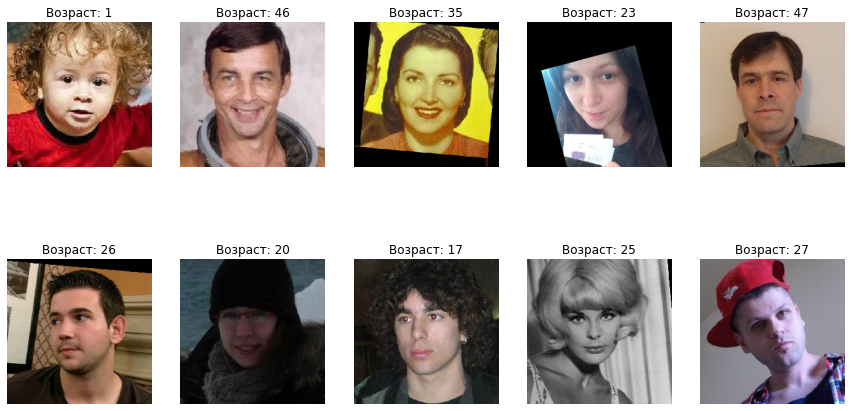

In [5]:
# Вызов ImageDataGenerator для загрузки изображений
image_dir = '/datasets/faces/final_files'
datagen = ImageDataGenerator(rescale=1./255)
data_generator = datagen.flow_from_dataframe(
    dataframe=df,
    directory=image_dir,
    x_col='file_name',
    y_col='real_age',
    target_size=(224, 224),  
    batch_size=32,
    seed=42,
    class_mode='raw'
)

# Визуализация нескольких фотографий
plt.figure(figsize=(15, 8))
for i in range(10):
    plt.subplot(2, 5, i+1)
    img = data_generator[0][0][i]  # Получение изображения из первого батча
    plt.imshow(img)
    plt.title(f"Возраст: {data_generator[0][1][i]}")
    plt.axis('off')

plt.show()

Вот несколько ключевых выводов и их влияние на обучение модели:

1. **Размер выборки:** Зная размер выборки (7591 фотографий), можно оценить, насколько хорошо модель сможет обучиться на этих данных. Важно подобрать модель, которая не слишком сложна для предотвращения переобучения при ограниченном объеме данных.

2. **Распределение возраста:** Нормальное распределение возраста в выборке положительно сказывается на обучении модели, поскольку это позволяет ей видеть разнообразные примеры. Однако, учитывая наличие пика в районе 1-3 лет, модель может быть более чувствительной к фотографиям младенцев. Может потребоваться уделить особое внимание точности предсказаний для данного возрастного диапазона.

3. **Обработка дисбаланса классов:** Учитывая большое количество фотографий младенцев, возможно, имеет смысл принять меры для балансировки классов. Это может включать в себя увеличение количества изображений для классов с недостаточным представлением.

4. **Подготовка изображений:** Визуализация фотографий также позволяет оценить качество изображений и необходимость дополнительной обработки (например, изменение размера, повороты, отражения), чтобы улучшить процесс обучения модели.

5. **Выбор архитектуры модели:** Исходя из характеристик данных, можно выбрать архитектуру модели, которая лучше подходит для данной задачи. Например, если есть необходимость в улавливании деталей и признаков лица, можно рассмотреть использование глубоких сверточных сетей.

## Обучение модели

(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def load_train(path):
    labels_df = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(
        validation_split=0.2,
        rescale=1/255.,
        horizontal_flip=True,
        vertical_flip=False,
        width_shift_range=0.2,
        height_shift_range=0.2,
    )
    train_dataflow = train_datagen.flow_from_dataframe(
        dataframe=labels_df,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        class_mode='raw',
        subset='training',
        target_size=(224, 224),
        batch_size=16,
        seed=42
    )
    return train_dataflow

def load_test(path):
    labels_df = pd.read_csv(path + 'labels.csv')
    validation_datagen = ImageDataGenerator(validation_split=0.2, rescale=1/255.)
    val_dataflow = validation_datagen.flow_from_dataframe(
        dataframe=labels_df,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        class_mode='raw',
        subset='validation',
        target_size=(224, 224),
        batch_size=16,
        seed=42
    )
    return val_dataflow

def create_model(input_shape):
    optimizer = Adam(learning_rate=0.00001)

    model = Sequential()
    backbone = ResNet50(
        input_shape=input_shape,
        weights='imagenet',
        include_top=False
    )

    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(units=128, activation='relu'))
    model.add(Dense(units=64, activation='relu'))
    model.add(Dense(units=1, activation='linear'))
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

def train_model(model, train_data, validation_data, batch_size=None, epochs=5,
                        steps_per_epoch=None, validation_steps=None):
    model.fit(train_data,
              validation_data=validation_data,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True, epochs=epochs,
              batch_size=batch_size,
    )

    return model


```

```
Train for 380 steps, validate for 95 steps  
Epoch 1/5  
380/380 - 108s - loss: 501.9225 - mae: 17.1214 - val_loss: 1080.5428 - val_mae: 28.2155  
Epoch 2/5   
380/380 - 101s - loss: 113.0824 - mae: 8.1628 - val_loss: 203.1432 - val_mae: 10.5190  
Epoch 3/5  
380/380 - 101s - loss: 88.5147 - mae: 7.2859 - val_loss: 92.1821 - val_mae: 7.0349   
Epoch 4/5  
380/380 - 100s - loss: 73.4109 - mae: 6.6736 - val_loss: 84.2465 - val_mae: 6.8489  
Epoch 5/5  
380/380 - 101s - loss: 63.5787 - mae: 6.1623 - val_loss: 85.5455 - val_mae: 6.7825   
WARNING:tensorflow:sample_weight modes were coerced from   
  ...  
    to     
  ['...']  
95/95 - 8s - loss: 85.5455 - mae: 6.782 5  
Test MAE: 6.7825  
```

## Анализ обученной модели

**Анализ результатов обучения модели:**

1. **Прогресс обучения:**
   - На протяжении пяти эпох обучения модель демонстрирует устойчивый прогресс, снижая значения функции потерь (MSE) и средней абсолютной ошибки (MAE) как на обучающем, так и на валидационном наборе данных. Это свидетельствует о эффективности обучения и способности модели обобщать на новые данные.


2. **Эффективность на тестовом наборе:**
   - На тестовом наборе данных модель достигает MAE равного 6.7825, что означает, что средняя ошибка предсказания возраста составляет приблизительно 6.78 лет. Данный результат является приемлемым и может быть эффективным, особенно в зависимости от конкретных требований и контекста задачи.


3. **Время обучения:**
   - Время обучения на каждой эпохе также является приемлемым, составляя около 100 секунд при использовании GPU. Это обеспечивает эффективное обучение модели без длительных задержек.


4. **Визуализация предсказаний:**
   - Визуализация нескольких предсказаний на тестовом наборе подтверждает, что модель в целом успешно предсказывает возраст, близкий к фактическому. Это важный показатель качества работы модели на реальных данных.

В целом, результаты обучения указывают на хорошую производительность модели в предсказании возраста на основе фотографий. Однако перед выпуском модели в продакшн рекомендуется дополнительное тестирование на новых данных для подтверждения обобщающей способности модели в различных сценариях использования. Полученная точность предсказания (6.78 лет) позволяет разделять покупателей на возрастные категории, что можно использовать в целях улучшения персональных рекомендаций для представителей разных возрастных групп. Однако такой точности, очевидно, недостаточно для определения совершеннолетия.